In [1]:
using Pkg
Pkg.activate("..")
using Dispersions
using Test
using FFTW
include("../test/helper_functions.jl")

  Activating project at `~/Codes/Dispersions.jl`
[ Info: Precompiling Dispersions [9451dd48-6b2a-4bde-a443-9ec270a37806]


transform_k_to_minus_k (generic function with 1 method)

In [68]:
Ns = 20


gr = "2Dsc-1.1-0.5-0.1"
kG = gen_kGrid(gr, Ns)

v_full = collect(Dispersions.gen_sampling(grid_type(kG), 2, Ns))
q0 = Tuple(findfirst(x-> all(x .≈ 0), v_full))

arr1 = randn(ComplexF64, gridshape(kG))
arr2 = randn(ComplexF64, gridshape(kG))
arr1_sym = expandKArr(kG, reduceKArr(kG, arr1))
arr2_sym = expandKArr(kG, reduceKArr(kG, arr2))
arr1_c = deepcopy(arr1_sym)
arr2_c = deepcopy(arr2_sym);

In [69]:
res_pp, dbg_i_pp, dbg_val_pp = naive_conv(v_full, v_full, pp=true, q0, round_entries=false);
res_ph, dbg_i, dbg_val = naive_conv(v_full, v_full, pp=false, q0, round_entries=false);

In [70]:
q_list = map(el->check_q(el, Ns), dbg_val);
# preprocess rounds all entries in order for unqiue to work
q_list_pre = map(x -> map(xi -> round.(xi,digits=8), x), q_list)
q_list_pre = map(x -> map(xi -> map(xii -> xii ≈ 0 ? abs(xii) : xii, xi), x), q_list_pre)
# Test if all entries have the same common q difference
@test all(map(qi_list -> length(unique(qi_list)) == 1, q_list_pre))
# Extract only q vector (since we checked that only one unique exists
q_list_single = map(x->x[1], q_list_pre)
# Test if all q-vectors are at the correct index
@test all(map(x-> all(x[1] .≈ x[2]), zip(q_list_single, v_full)))
# Test if all possible q-vectors are contained in convolution
@test all(map(el -> all(el[1] .≈ el[2]), zip(sort(unique(v_full)[:]), sort(map(qi->qi[1], q_list_pre)[:]))))
# Test if all combinations of k_i and k_{i+j} are contained in each result index
@test all(map(entry -> length(unique(map(x->x[1], entry))), dbg_val) .== Ns*Ns)
@test all(map(entry -> length(unique(map(x->x[2], entry))), dbg_val) .== Ns*Ns)

Test Passed

In [71]:
q_list_pp = map(el->check_q(el, Ns, pp=true), dbg_val_pp);
# preprocess rounds all entries in order for unqiue to work
q_list_pp_pre = map(x -> map(xi -> round.(xi,digits=8), x), q_list_pp)
q_list_pp_pre = map(x -> map(xi -> map(xii -> xii ≈ 0 ? abs(xii) : xii, xi), x), q_list_pp_pre)
# Test if all entries have the same common q difference
@test all(map(qi_list -> length(unique(qi_list)) == 1, q_list_pp_pre))
# extract only q vector (since we checked that only one unique exists
q_list_pp_single = map(x->x[1], q_list_pp_pre)
# test if all q-vectors are at the correct index
@test all(map(x-> all(x[1] .≈ x[2]), zip(q_list_pp_single, v_full)))
# Test if all possible q-vectors are contained in convolution
@test all(map(el -> all(el[1] .≈ el[2]), zip(sort(unique(v_full)[:]), sort(map(qi->qi[1], q_list_pp_pre)[:]))))
# Test if all combinations of k_i and k_{i+j} are contained in each result index
@test all(map(entry -> length(unique(map(x->x[1], entry))), dbg_val_pp) .== Ns*Ns)
@test all(map(entry -> length(unique(map(x->x[2], entry))), dbg_val_pp) .== Ns*Ns)

Test Passed

In [72]:
conv_ph_naive,_,_ = naive_conv(arr1_sym, arr2_sym, q0, pp=false);
conv_test = Dispersions.conv(kG, reduceKArr(kG,arr1_sym), reduceKArr(kG,arr2_sym), crosscorrelation=true)
conv_ph_fft_test = circshift(reverse(ifft(fft(arr1_sym) .* fft(reverse(arr2_sym)))), q0 .- 1)

show(stdout, "text/plain", expandKArr(kG, conv_test))
println("\n===============================")
show(stdout, "text/plain", kG.cache1 ./ kG.Nk)
println("\n===============================")
show(stdout, "text/plain", conv_ph_naive ./ kG.Nk)
println("\n===============================")
show(stdout, "text/plain", conv_ph_fft_test ./ kG.Nk)

@test all(conv_ph_fft_test .≈ conv_ph_naive)
@test all(conv_ph_fft_test .≈ expandKArr(kG, conv_test) .* kG.Nk)

20×20 Matrix{ComplexF64}:
  -0.0780359+0.0831351im   -0.0517528+0.0413885im    -0.00201495+0.0139768im     0.0251038-0.0162771im     0.0683155+0.00756266im   0.00669482-0.0338669im    0.0104043+0.00117825im  -0.00704748-0.0200467im   -0.0139033+0.0280063im     -0.0353365+0.00994929im  -0.0139033+0.0280063im    -0.00704748-0.0200467im    0.0104043+0.00117825im   0.00669482-0.0338669im     0.0683155+0.00756266im    0.0251038-0.0162771im   -0.00201495+0.0139768im   -0.0517528+0.0413885im     -0.0780359+0.0831351im    -0.0180945+0.117085im
  -0.0517528+0.0413885im    0.0420565+0.0299443im     0.00223907-0.0215005im    0.00177879-0.0336218im     0.0223112+0.0434929im     0.0577036-0.00530388im  -0.0178483-0.0421129im     0.0297875-0.0232946im   -0.0286499+0.000582644im    0.0484709+0.00475151im  -0.0286499+0.000582644im    0.0297875-0.0232946im   -0.0178483-0.0421129im     0.0577036-0.00530388im    0.0223112+0.0434929im    0.00177879-0.0336218im    0.00223907-0.0215005im    0.0420565+0.0299

Test Passed

In [73]:
conv_pp_naive,_,_ = naive_conv(arr1_sym, arr2_sym, q0, pp=true);
conv_pp_test = Dispersions.conv(kG, reduceKArr(kG,arr1_sym), reduceKArr(kG, arr2_sym), crosscorrelation=false)
conv_pp_fft_test = circshift(ifft(fft(arr1_sym) .* fft(arr2_sym)), -0 .* q0 .+ 2)

#show(stdout, "text/plain", expandKArr(kG, conv_pp_test))
#println("\n===============================")
#show(stdout, "text/plain", kG.cache1 ./ kG.Nk)
#println("\n===============================")
show(stdout, "text/plain", conv_pp_naive  ./ kG.Nk )
println("\n===============================")
show(stdout, "text/plain", conv_pp_fft_test ./ kG.Nk)

@test all(conv_pp_fft_test .≈ conv_pp_naive)
@test all(conv_pp_fft_test ./ kG.Nk .≈ expandKArr(kG, conv_pp_test))

20×20 Matrix{ComplexF64}:
  -0.0780359+0.0831351im   -0.0517528+0.0413885im    -0.00201495+0.0139768im     0.0251038-0.0162771im     0.0683155+0.00756266im   0.00669482-0.0338669im    0.0104043+0.00117825im  -0.00704748-0.0200467im   -0.0139033+0.0280063im     -0.0353365+0.00994929im  -0.0139033+0.0280063im    -0.00704748-0.0200467im    0.0104043+0.00117825im   0.00669482-0.0338669im     0.0683155+0.00756266im    0.0251038-0.0162771im   -0.00201495+0.0139768im   -0.0517528+0.0413885im     -0.0780359+0.0831351im    -0.0180945+0.117085im
  -0.0517528+0.0413885im    0.0420565+0.0299443im     0.00223907-0.0215005im    0.00177879-0.0336218im     0.0223112+0.0434929im     0.0577036-0.00530388im  -0.0178483-0.0421129im     0.0297875-0.0232946im   -0.0286499+0.000582644im    0.0484709+0.00475151im  -0.0286499+0.000582644im    0.0297875-0.0232946im   -0.0178483-0.0421129im     0.0577036-0.00530388im    0.0223112+0.0434929im    0.00177879-0.0336218im    0.00223907-0.0215005im    0.0420565+0.0299

LoadError: [91mThere was an error during testing[39m

In [74]:
@test all(arr1_c .== arr1_sym)
@test all(arr2_c .== arr2_sym)

Test Passed

# k-k'

In [75]:
all(map(x-> all(x[1] .≈ x[2]) , zip(k_plus_q, k_plus_q2[:])))

LoadError: UndefVarError: `k_plus_q` not defined

In [76]:
v_full
show(stdout, "text/plain", v_full)

20×20 Matrix{Tuple{Float64, Float64}}:
 (-2.82743, -2.82743)   (-2.82743, -2.51327)   (-2.82743, -2.19911)   (-2.82743, -1.88496)   (-2.82743, -1.5708)   (-2.82743, -1.25664)   (-2.82743, -0.942478)   (-2.82743, -0.628319)   (-2.82743, -0.314159)   (-2.82743, 0.0)   (-2.82743, 0.314159)   (-2.82743, 0.628319)   (-2.82743, 0.942478)   (-2.82743, 1.25664)   (-2.82743, 1.5708)   (-2.82743, 1.88496)   (-2.82743, 2.19911)   (-2.82743, 2.51327)   (-2.82743, 2.82743)   (-2.82743, 3.14159)
 (-2.51327, -2.82743)   (-2.51327, -2.51327)   (-2.51327, -2.19911)   (-2.51327, -1.88496)   (-2.51327, -1.5708)   (-2.51327, -1.25664)   (-2.51327, -0.942478)   (-2.51327, -0.628319)   (-2.51327, -0.314159)   (-2.51327, 0.0)   (-2.51327, 0.314159)   (-2.51327, 0.628319)   (-2.51327, 0.942478)   (-2.51327, 1.25664)   (-2.51327, 1.5708)   (-2.51327, 1.88496)   (-2.51327, 2.19911)   (-2.51327, 2.51327)   (-2.51327, 2.82743)   (-2.51327, 3.14159)
 (-2.19911, -2.82743)   (-2.19911, -2.51327)   (-2.19911, -2.1991

In [77]:
minus_v_full = map(x-> -1 .* x, v_full)
show(stdout, "text/plain", minus_v_full)

20×20 Matrix{Tuple{Float64, Float64}}:
 (2.82743, 2.82743)    (2.82743, 2.51327)    (2.82743, 2.19911)    (2.82743, 1.88496)    (2.82743, 1.5708)    (2.82743, 1.25664)    (2.82743, 0.942478)    (2.82743, 0.628319)    (2.82743, 0.314159)    (2.82743, -0.0)    (2.82743, -0.314159)    (2.82743, -0.628319)    (2.82743, -0.942478)    (2.82743, -1.25664)    (2.82743, -1.5708)    (2.82743, -1.88496)    (2.82743, -2.19911)    (2.82743, -2.51327)    (2.82743, -2.82743)    (2.82743, -3.14159)
 (2.51327, 2.82743)    (2.51327, 2.51327)    (2.51327, 2.19911)    (2.51327, 1.88496)    (2.51327, 1.5708)    (2.51327, 1.25664)    (2.51327, 0.942478)    (2.51327, 0.628319)    (2.51327, 0.314159)    (2.51327, -0.0)    (2.51327, -0.314159)    (2.51327, -0.628319)    (2.51327, -0.942478)    (2.51327, -1.25664)    (2.51327, -1.5708)    (2.51327, -1.88496)    (2.51327, -2.19911)    (2.51327, -2.51327)    (2.51327, -2.82743)    (2.51327, -3.14159)
 (2.19911, 2.82743)    (2.19911, 2.51327)    (2.19911, 2.19911)

In [78]:
shift_vec = 2 .* kG.k0 .- gridshape(kG) .- 1
minus_v_full2 = circshift(reverse(v_full), shift_vec)
show(stdout, "text/plain", minus_v_full2)

20×20 Matrix{Tuple{Float64, Float64}}:
 (2.82743, 2.82743)    (2.82743, 2.51327)    (2.82743, 2.19911)    (2.82743, 1.88496)    (2.82743, 1.5708)    (2.82743, 1.25664)    (2.82743, 0.942478)    (2.82743, 0.628319)    (2.82743, 0.314159)    (2.82743, 0.0)    (2.82743, -0.314159)    (2.82743, -0.628319)    (2.82743, -0.942478)    (2.82743, -1.25664)    (2.82743, -1.5708)    (2.82743, -1.88496)    (2.82743, -2.19911)    (2.82743, -2.51327)    (2.82743, -2.82743)    (2.82743, 3.14159)
 (2.51327, 2.82743)    (2.51327, 2.51327)    (2.51327, 2.19911)    (2.51327, 1.88496)    (2.51327, 1.5708)    (2.51327, 1.25664)    (2.51327, 0.942478)    (2.51327, 0.628319)    (2.51327, 0.314159)    (2.51327, 0.0)    (2.51327, -0.314159)    (2.51327, -0.628319)    (2.51327, -0.942478)    (2.51327, -1.25664)    (2.51327, -1.5708)    (2.51327, -1.88496)    (2.51327, -2.19911)    (2.51327, -2.51327)    (2.51327, -2.82743)    (2.51327, 3.14159)
 (2.19911, 2.82743)    (2.19911, 2.51327)    (2.19911, 2.19911)    

In [79]:
transform_k_to_minus_k(k) = map(ki -> ki != 0 ? mod.(-1 .* ki .+ π .- 1/Nk(kG), 2π) .- π .+ 1/Nk(kG) : ki, k)
minus_vec_naive = map(transform_k_to_minus_k, v_full)
@test all(map(x-> all(x[1] .≈ x[2]), zip(minus_vec_naive, minus_v_full2)))

Test Passed

In [80]:
v_full = collect(Dispersions.gen_sampling(grid_type(kG), grid_dimension(kG), kG.Ns))
q_lookup = Dispersions.build_q_lookup(kG)
result   = Array{Int,2}(undef, length(v_full), length(v_full))
fails = []
for k in v_full
    for kp in v_full
        q_test = round.(transform_to_first_BZ(kG, k .- kp), digits=6)
        !(q_test in keys(q_lookup)) && push!(fails, q_test)
    end
end
println("number of fails: ", length(fails))

number of fails: 0


In [81]:
dispersion(kG)
ek0 = expandKArr(kG, dispersion(kG))
ek1 = Matrix{Float64}(undef, length(ek0), length(ek0))
for (ki,k) in enumerate(v_full)
    for (kpi,kp) in enumerate(v_full)
        q_test1 = round.(transform_to_first_BZ(kG, k .- kp), digits=6)
        #!(q_test in keys(q_lookup)) && push!(fails, q_test)
        ek1[ki,kpi] = dispersion(kG)[q_lookup[q_test1]]
    end
end

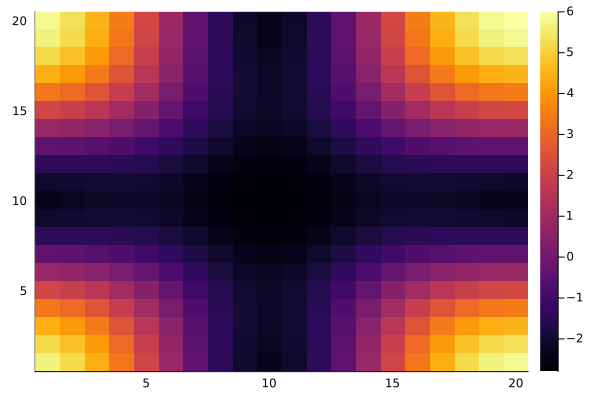

In [84]:
using Plots
k0ind = findfirst(x-> all(x .≈ 0),v_full[:])
heatmap(reshape(ek1[:,k0ind], gridshape(kG)))

[ Info: Saved animation to /home/julisn/Codes/Dispersions.jl/notebooks/tmp.gif


Plots.AnimatedGif("/home/julisn/Codes/Dispersions.jl/notebooks/tmp.gif")
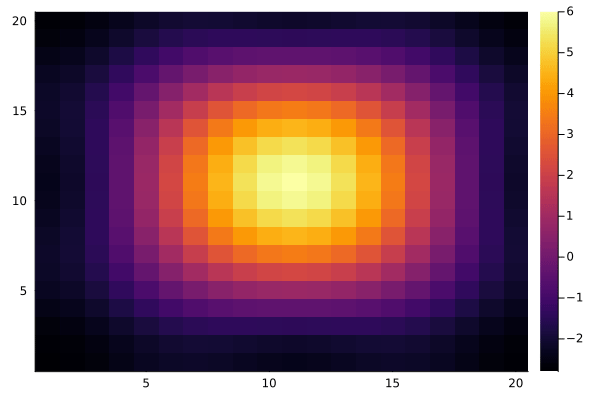

In [83]:
@gif for i in 1:size(ek1,2)
    heatmap(reshape(ek1[:,i], gridshape(kG)))
end